# Hands-on Machine Learning with Scikit-learn, Keras and Tensorflow - Ch3 (Part 2)
- categories: [MachineLearning, Notes, Classification]

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np


mnist = fetch_openml('mnist_784', version=1)

In [3]:
data, target = mnist.data, mnist.target
x_train, y_train, x_test, y_test = data[:60000], target[:60000], data[60000:], target[60000:]

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

# sometime (very rarely) we might want to train a one vs one classifier instead of one vs all classifier
sgd = SGDClassifier(random_state=2)
sgd_ovo = OneVsOneClassifier(SGDClassifier(random_state=2))

sgd.fit(x_train, y_train)
sgd_ovo.fit(x_train, y_train)

# SGDClassifier will automatically stack one vs all classifier while working with multi-class
print('The shape of weights of default SGD multi-class classifier is:', sgd.coef_.shape)

# training the classifier in a one vs one way means training '1' vs '2', '1' vs '3'... 45 estimators
# prediction will pick the label winning the most in all estimators
print('There are %d estimater in one vs one SGDClassifier.' % len(sgd_ovo.estimators_))
print(sgd_ovo.estimators_[0].coef_.shape)

The shape of weights of default SGD multi-class classifier is: (10, 784)
There are 45 estimater in one vs one SGDClassifier.
(1, 784)


Of course some classifier like decision tree can classify multi-class in its original form (different class are different leaf in the case of decision tree).

In [12]:
from sklearn.preprocessing import StandardScaler
import numpy as np


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

In [16]:
from sklearn.model_selection import cross_val_score


result = cross_val_score(SGDClassifier(random_state=2, n_jobs=-1), x_train, y_train, cv=3, scoring='accuracy')
print('without scaling, the accuracy is %f +/- %f' % (result.mean(), result.std()))

result2 = cross_val_score(SGDClassifier(random_state=2, n_jobs=-1), x_train_scaled, y_train, cv=3, scoring='accuracy')
print('with scaling, the accuracy is %f +/- %f' % (result2.mean(), result2.std()))

without scaling, the accuracy is 0.872133 +/- 0.002477


/Users/sk/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


with scaling, the accuracy is 0.897383 +/- 0.005675


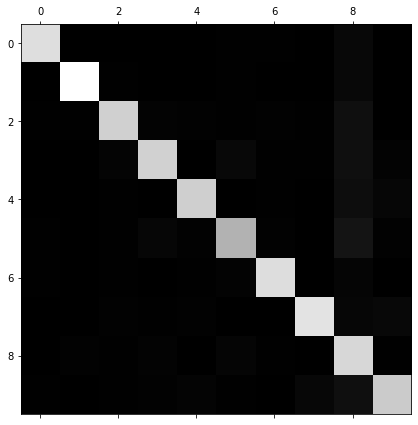

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict


# for error analysis, confusion matrix could help us analysis which class the model perform badly
pred = cross_val_predict(sgd, x_train_scaled, y_train, cv=3, n_jobs=-1)
confusion = confusion_matrix(y_train, pred)
fig = plt.figure(figsize=(7, 7))
plt.matshow(confusion, cmap=plt.cm.gray, fignum=fig.number)
plt.show()

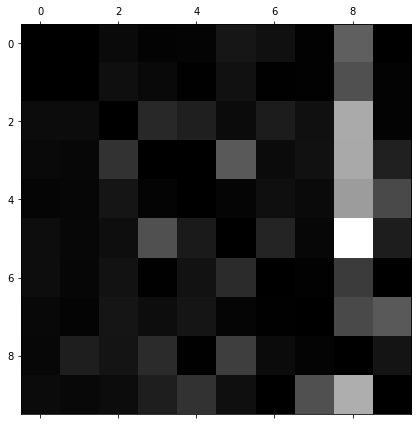

In [28]:
# normalized by number of each class and remove the diagonal (True positive) element
num_class = confusion.sum(axis=1, keepdims=True)
cm_norm = confusion / num_class

np.fill_diagonal(cm_norm, 0)
fig = plt.figure(figsize=(7, 7))
plt.matshow(cm_norm, cmap=plt.cm.gray, fignum=fig.number)
plt.show()

Now we can see that the model tends to mis-classify other sample as '8', while for the real '8's actually the model preforming okay. To improve the model, we can, for example, gather more samples looks like '8' or introducing new features helping the identify a non-'8' figure.

## Multilabel Classification

Sometimes our task is not just identify the letter of the hand-written number, for example to identify multi-person's face in the picture, or to classify what topics a paragraph is about, in which the authors put the task as "multilabel" classification. In practice a simple solution is training one to all model for each label, and replace the picking the highest predict_proba to a threshold, and put the label on if the probability is higher than the threshold.